# Self-Explaining Neural Networks with Disentanglement
---

## Import libraries

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from types import SimpleNamespace
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
from models.losses import *
from models.parameterizer import ConvParameterizer
from models.conceptizer import ConvConceptizer, VaeConceptizer
from models.aggregator import SumAggregator

## Configuration

In [4]:
plt.style.use('seaborn-paper')

In [5]:
config = {
  "model_class": "DiSENN",
  "conceptizer": "VaeConceptizer",
  "pretrain_epochs": 3,
  "beta": 4.0,
  "concept_loss": "BVAE_loss",
  "robustness_loss": "mnist_robustness_loss",
  "train": True,
  "image_size": 28,
  "concept_dim": 1,
  "concept_visualization": None,
  "parameterizer": "ConvParameterizer",
  "cl_sizes": [1, 10, 20],
  "hidden_sizes": [320, 50],
  "num_concepts": 5,
  "num_classes": 10,
  "dropout": 0.5,
  "aggregator": "SumAggregator",
  "device": "cuda:0",
  "lr": 2e-3,
  "epochs": 5,
  "robust_reg": 1e-3,
  "concept_reg": 1,
  "print_freq": 50,
  "exp_name": "mnist_bvae_concepts10",
  "dataloader": "mnist",
  "data_path": "datasets/data/mnist_data",
  "batch_size" : 128,
  "eval_freq" : 100
}
config = SimpleNamespace(**config)

# DiSENN
DiSENN (Self-Explaining Neural Networks with Disentanglement) is an extension of the Self-Explaining Neural Network proposed by [1]  

DiSENN incorporates a constrained variational inference framework on a 
SENN Concept Encoder to learn disentangled representations of the 
basis concepts as in [2]. The basis concepts are then independently
sensitive to single generative factors leading to better interpretability 
and lesser overlap with other basis concepts. Such a strong constraint 
better fulfills the "diversity" desiderata for basis concepts
in a Self-Explaining Neural Network.


References  
[1] Alvarez Melis, et al.
"Towards Robust Interpretability with Self-Explaining Neural Networks" NIPS 2018  
[2] Irina Higgins, et al. 
”β-VAE: Learning basic visual concepts with a constrained variational framework.” ICLR 2017. 

In [6]:
class DiSENN(nn.Module):
    """Self-Explaining Neural Network with Disentanglement """
    
    def __init__(self, vae_conceptizer, parameterizer, aggregator):
        """Instantiates the SENDD with a variational conceptizer, parameterizer and aggregator"""
        super().__init__()
        self.vae_conceptizer = vae_conceptizer
        self.parameterizer = parameterizer
        self.aggregator = aggregator

    def forward(self, x):
        """Forward pass of a DiSENN model
        
        The forward pass computes a distribution over basis concepts
        and the corresponding relevance scores. The mean concepts 
        and relevance scores are aggregated to generate a prediction.
        """
        concept_mean, concept_logvar, x_reconstruct = self.vae_conceptizer(x)
        relevances = self.parameterizer(x)
        predictions = self.aggregator(concept_mean, relevances)
        explanations = ((concept_mean, concept_logvar), relevances)
        return predictions, explanations, x_reconstruct

## Load Data

In [7]:
from datasets.dataloaders import get_dataloader
train_dl, val_dl, _ = get_dataloader(config)

## Training

In [8]:
from trainer import Trainer

In [9]:
trainer = Trainer(config)
trainer.run()
trainer.finalize()

Using device cuda:0
Loading data ...
Pre-training the Conceptizer... 
EPOCH:0 STEP:0 	Concept Loss: 1.257
EPOCH:0 STEP:50 	Concept Loss: 0.835
EPOCH:0 STEP:100 	Concept Loss: 0.817
EPOCH:0 STEP:150 	Concept Loss: 0.818
EPOCH:0 STEP:200 	Concept Loss: 0.796
EPOCH:0 STEP:250 	Concept Loss: 0.819
EPOCH:0 STEP:300 	Concept Loss: 0.810
EPOCH:0 STEP:350 	Concept Loss: 0.802
EPOCH:0 STEP:400 	Concept Loss: 0.826
EPOCH:1 STEP:0 	Concept Loss: 0.788
EPOCH:1 STEP:50 	Concept Loss: 0.803
EPOCH:1 STEP:100 	Concept Loss: 0.851
EPOCH:1 STEP:150 	Concept Loss: 0.821
EPOCH:1 STEP:200 	Concept Loss: 0.804
EPOCH:1 STEP:250 	Concept Loss: 0.778
EPOCH:1 STEP:300 	Concept Loss: 0.765
EPOCH:1 STEP:350 	Concept Loss: 0.800
EPOCH:1 STEP:400 	Concept Loss: 0.771
EPOCH:2 STEP:0 	Concept Loss: 0.773
EPOCH:2 STEP:50 	Concept Loss: 0.782
EPOCH:2 STEP:100 	Concept Loss: 0.818
EPOCH:2 STEP:150 	Concept Loss: 0.822
EPOCH:2 STEP:200 	Concept Loss: 0.800
EPOCH:2 STEP:250 	Concept Loss: 0.806
EPOCH:2 STEP:300 	Concept L

<Figure size 748.8x514.8 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

## Load Trained Model

In [10]:
conceptizer = eval(config.conceptizer)(**config.__dict__)
parameterizer = eval(config.parameterizer)(**config.__dict__)
aggregator = eval(config.aggregator)(**config.__dict__)

In [11]:
model = DiSENN(conceptizer, parameterizer, aggregator)

In [12]:
checkpoint_path = Path('results')
model_file = checkpoint_path / config.exp_name / "checkpoints" / "best_model.pt" 
checkpoint = torch.load(model_file, config.device)
print(f"Loading trained model: {model_file}")

Loading trained model: results/mnist_bvae_concepts10/checkpoints/best_model.pt


In [13]:
model.load_state_dict(checkpoint['model_state'])

<All keys matched successfully>

# Classification

In [14]:
xb, yb = next(iter(val_dl))
y_pred, explanations, x_reconstruct = model(xb)

In [15]:
plt.rcParams['figure.figsize'] = (2, 2)

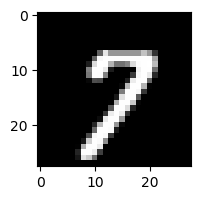

In [16]:
plt.imshow(xb[-1][0], cmap='gray')

In [17]:
y_pred.argmax(1), yb

(tensor([5, 7, 5, 7, 2, 7, 0, 2, 0, 5, 2, 6, 2, 7, 9, 0, 3, 7, 0, 1, 7, 8, 0, 5,
         0, 4, 7, 2, 8, 6, 4, 6, 0, 6, 3, 0, 1, 6, 6, 4, 6, 1, 8, 1, 0, 4, 9, 8,
         2, 3, 7, 4, 9, 7, 2, 1, 5, 6, 5, 7, 7, 2, 2, 2, 0, 8, 8, 5, 1, 9, 8, 9,
         0, 0, 9, 8, 2, 6, 2, 6, 1, 0, 2, 8, 9, 6, 3, 2, 0, 0, 4, 9, 6, 2, 2, 6,
         5, 6, 6, 1, 3, 4, 6, 8, 7, 1, 6, 8, 8, 8, 5, 3, 2, 3, 5, 4, 2, 3, 5, 4,
         3, 0, 3, 9, 1, 1, 3, 7]),
 tensor([5, 7, 8, 7, 2, 7, 8, 8, 0, 5, 1, 6, 2, 7, 9, 0, 3, 7, 6, 1, 7, 7, 0, 5,
         0, 4, 7, 2, 8, 6, 4, 6, 0, 6, 3, 6, 1, 6, 6, 4, 6, 1, 8, 1, 0, 4, 9, 8,
         6, 3, 7, 4, 4, 7, 4, 1, 5, 6, 5, 7, 7, 2, 2, 2, 3, 8, 8, 5, 1, 9, 8, 9,
         0, 0, 9, 2, 2, 6, 2, 6, 1, 0, 2, 8, 4, 6, 3, 2, 0, 8, 4, 9, 6, 2, 2, 6,
         4, 6, 6, 1, 3, 4, 6, 8, 7, 1, 6, 8, 8, 8, 5, 2, 2, 3, 9, 9, 2, 3, 5, 4,
         3, 2, 3, 9, 1, 1, 2, 7]))

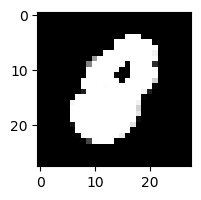

In [18]:
plt.imshow(x_reconstruct[-1][0].detach().numpy(), cmap='gray')

In [19]:
model = model.to(config.device)

In [20]:
accuracy = 0.
model.eval()
with torch.no_grad():
    for i, (x, labels) in enumerate(val_dl):
        x = x.float().to(config.device)
        labels = labels.long().to(config.device)
        y_pred, explanations, x_reconstructed = model(x)
        accuracy += (y_pred.argmax(axis=1) == labels).float().mean().item()
print(f"Test Mean Accuracy: {accuracy/i*100:.3f} %")

Test Mean Accuracy: 100.122 %


In [21]:
model = model.to(torch.device('cpu'))

# Explanation

## Generate Prototypes from Disentangled Concepts

In [22]:
num_prototypes = 20
traversal_range = 2

In [23]:
plt.rcParams['figure.figsize'] = (2, 2)

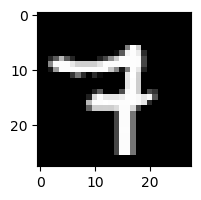

In [44]:
x = xb[1]
plt.imshow(x.numpy().squeeze(), cmap='gray')

In [45]:
y_pred, explanations, x_reconstruct = model(x.unsqueeze(0))
(x_posterior_mean, x_posterior_logvar), relevances = explanations
x_posterior_mean, x_posterior_logvar = x_posterior_mean.squeeze(-1), x_posterior_logvar.squeeze(-1)

In [46]:
concepts = x_posterior_mean.detach().numpy()
num_concepts = concepts.shape[1]
concepts_sample = model.vae_conceptizer.sample(x_posterior_mean, x_posterior_logvar).detach()

In [47]:
concepts_sample = concepts_sample.repeat(num_prototypes, 1)

In [48]:
concepts_sample

tensor([[ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.2095, -0.1868,  0.2509],
        [ 

In [49]:
def independent_traversal(matrix, dim, traversal_range=2, steps=num_prototypes):
    """Linearly traverses through one dimension of a matrix independently"""
    traversal = torch.linspace(-1 * traversal_range, traversal_range, steps)
    matrix_traversal = matrix.clone() # to avoid changing the matrix
    matrix_traversal[:, dim] = traversal
    return matrix_traversal

In [50]:
concepts_traversals = [independent_traversal(concepts_sample, dim) for dim in range(num_concepts)]

In [51]:
concepts_traversals[2]

tensor([[ 0.2520, -0.2547, -2.0000, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -1.7895, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -1.5789, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -1.3684, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -1.1579, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -0.9474, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -0.7368, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -0.5263, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -0.3158, -0.1868,  0.2509],
        [ 0.2520, -0.2547, -0.1053, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.1053, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.3158, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.5263, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.7368, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  0.9474, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  1.1579, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  1.3684, -0.1868,  0.2509],
        [ 0.2520, -0.2547,  1.5789, -0.1868,  0.2509],
        [ 

In [52]:
concepts_traversals = torch.cat(concepts_traversals, dim=0)

In [53]:
prototypes = model.vae_conceptizer.decoder(concepts_traversals)

In [54]:
prototypes.shape

torch.Size([100, 784])

In [55]:
prototype_imgs = prototypes.view((-1, 1, 28, 28))

In [56]:
prototype_imgs.shape

torch.Size([100, 1, 28, 28])

In [57]:
from torchvision.utils import make_grid

In [58]:
# nrow is number of images in a row which must be the number of prototypes
prototype_grid_img = make_grid(prototype_imgs, nrow=num_prototypes).detach().numpy()

In [59]:
prototype_grid_img.shape

(3, 152, 602)

<BarContainer object of 5 artists>

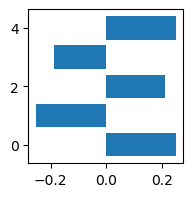

In [60]:
plt.barh(range(num_concepts), concepts.squeeze())

<BarContainer object of 5 artists>

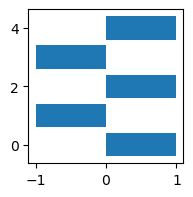

In [61]:
relevances = relevances.squeeze(0).detach().numpy()
plt.barh(range(num_concepts), relevances[:,y_pred.argmax(1)])

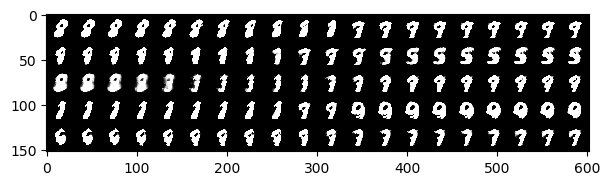

In [62]:
plt.rcParams['figure.figsize'] = (7, 7)
plt.imshow(prototype_grid_img.transpose(1,2,0))

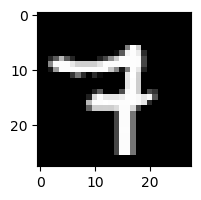

In [63]:
plt.rcParams['figure.figsize'] = (2,2)
plt.imshow(x.numpy().squeeze(), cmap='gray')